In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as tfk
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel, TFXLMRobertaForMaskedLM

## Model

In [2]:
tokenizer  = XLMRobertaTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')
xlmr_model = TFXLMRobertaModel.from_pretrained('jplu/tf-xlm-roberta-base')
xlmr_model.trainable = False
xlmr_model.summary()

Some weights of the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "tfxlm_roberta_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  278043648 
Total params: 278,043,648
Trainable params: 0
Non-trainable params: 278,043,648
_________________________________________________________________


In [3]:
def gelu(x):
    """ Gaussian Error Linear Unit.
    Original Implementation of the gelu activation function in Google Bert repo when initially created.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    cdf = 0.5 * (1.0 + tf.math.erf(x / tf.math.sqrt(2.0)))
    return x * cdf


class LanguageModelHead(tf.keras.layers.Layer):
    def __init__(self, input_embeddings, hidden_size, vocab_size=250002, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(hidden_size, activation=gelu, name="dense")
        self.layer_norm = tf.keras.layers.LayerNormalization(name="layer_norm")
        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = input_embeddings
    
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(self.vocab_size,), initializer="zeros", trainable=True, name="bias")
        super().build(input_shape)
    
    def call(self, features):
        # before this call: LM learns embeddings with language-specific features
        
        # linearly project embeddings
        # (rotate, stretch, squeeze, etc.)
        x = self.dense(features)
        # de-language the embeddings
        # (normalize embeddings to have mean=0 & std=1)
        x = self.layer_norm(x)
        # project back to words
        x = self.decoder(x, mode="linear") + self.bias
        
        # we can mask unused tokens here
        
        # output shape: [batch_size, length, vocab_size]
        return x

In [19]:
input_len  = 64
hidden_len = 1024
lan_emb_len = 768

input_tokens = tfk.layers.Input(shape=(input_len,), name='input_tokens', dtype='int32')
token_embeddings = xlmr_model(input_tokens)[0]

input_lang   = tfk.layers.Input(shape=(1,), name='input_lang', dtype='int32')
lang_embeddings  = tfk.layers.Embedding(2, lan_emb_len, name='lang_embeddings')(input_lang)

x = tfk.layers.Add(name='add_embeddings')([token_embeddings, lang_embeddings])
x = LanguageModelHead(xlmr_model.get_input_embeddings(), hidden_len, name='lm_head')(x)
model = tf.keras.Model(inputs=[input_tokens, input_lang], outputs=x, name='XLMR-TCN-EN')
model.summary()

Model: "XLMR-TCN-EN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tokens (InputLayer)       [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_lang (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober ((None, 64, 768), (N 278043648   input_tokens[0][0]               
__________________________________________________________________________________________________
lang_embeddings (Embedding)     (None, 1, 768)       1536        input_lang[0][0]                 
________________________________________________________________________________________

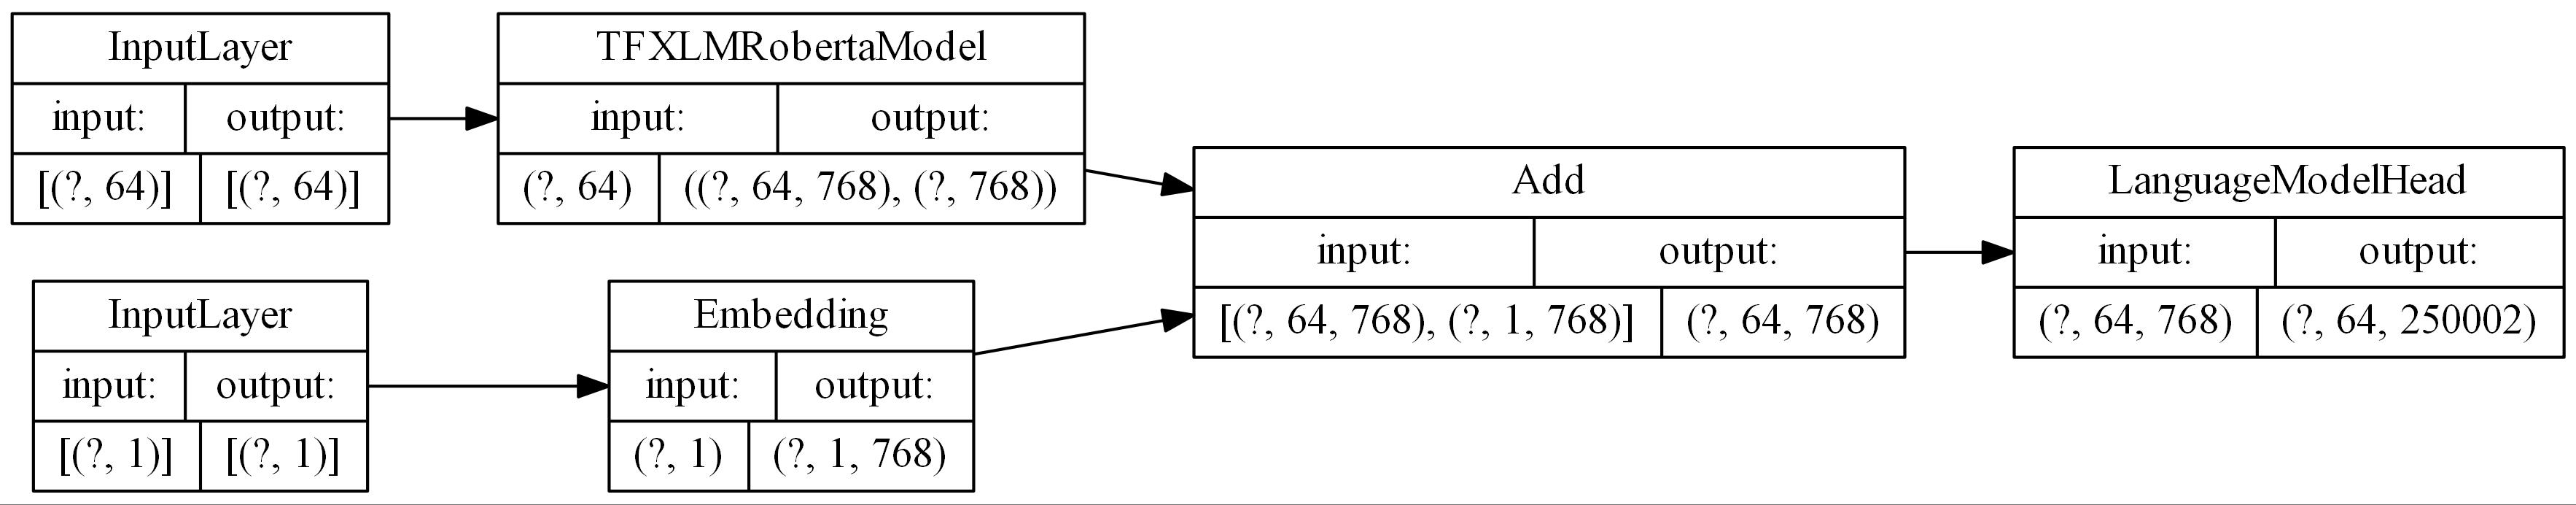

In [26]:
tfk.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=300, to_file='model_architecture.jpg')

In [14]:
input_sentence = "̅✳♤卡通辛普森兒童衛<mask>圓領男潮童洋氣小寶寶女童卡通<mask>加絨上衣"
input_tokens = tf.constant(tokenizer.encode(input_sentence,
                                            add_special_tokens=True,
                                            max_length=input_len,
                                            truncation=True,
                                            padding='max_length'))[None, :]
input_tokens.shape

TensorShape([1, 64])

In [15]:
input_tokens

<tf.Tensor: shape=(1, 64), dtype=int32, numpy=
array([[     0,      6, 243739, 246528, 245957, 188991,  39197,  16019,
         15498,  40419,  40742, 250001,      6,  36473,  24466,   8553,
         25882,  26578,  21764,   7670,   1128,  76715,   4870,  26578,
        188991, 250001,      6,   3490, 203853,    575,  11939,      2,
             1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1]])>

In [ ]:
N = 15
K = 3
noise = np.random.uniform(0, K+1, size=(N,))
noise[0] = -1
perm = np.arange(N) + noise
perm.argsort()